# 2021 NFL Big Data Bowl

### Analyzing schemes and players that make for a successful against passing plays.

##### Goal: Assist NFL defensive coordinators and defensive backs coaches with game planning by providing recommended situational matchups for Receivers/CBs.

##### Approach:

Perform a 3-step analysis using player tracking data from all 2018 pass plays (see data [here](https://www.kaggle.com/c/nfl-big-data-bowl-2021/data)):
  1. Develop profiles for CBs/WRs based on physical abilities (height, weight, experience, speed, etc.)
  2. Measure success rates and tendencies for given routes & coverages
  3. Provide a customized recommendation algorithm to suggest optimal player matchups for a number of common scenarios (1st & 10, 3rd & long, red-zone, goal line, etc.)


### 1. CB and WR profiles

##### 1A. Dividing players based on height percentiles

This first stab uses the distribution of height among CBs and WRs to split the players into 3 groups for each position (small/medium/big).



In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LinearRegression

### Stuff created by me
sys.path.append(r"C:\Users\mtdic\Documents\GitHub\big_data_bowl_2021")
import viz_util as viz
import data_util as du

os.chdir(r"E:/NFL/big_data_bowl/2021")

In [2]:
#### Non-Tracking Data Import and Cleaning
#includes schedule info for games
df_games = pd.read_csv("data/provided/games.csv")

#includes play-by-play info on specific plays
df_plays = pd.read_csv("data/provided/plays.csv")

#includes background info for players
df_players = pd.read_csv("data/provided/players.csv")
df_players['height'] = du.standardize_heights(df_players['height'])
std_birthdates, ages = du.convert_birthdates_to_ages(df_players['birthDate'])
df_players['birthDate'] = std_birthdates
df_players['age'] = ages

### BONUS Data: 
df_targets = pd.read_csv("data/provided/targetedReceiver.csv")


In [3]:
## Read in tracking data iteratively, filtering to goal line plays
WEEKS = list(range(1,18))
tracking_dfs = []
for w in WEEKS:
    df_tracking = pd.read_csv(f"data/provided/week{w}.csv")
    df_tracking = df_tracking[(df_tracking['position'].isin(['WR', 'CB'])) | 
                              (df_tracking['displayName'] == 'Football')]
    df_tracking = df_tracking.merge(df_games[['gameId', 'homeTeamAbbr','visitorTeamAbbr']], on = 'gameId')
    tracking_dfs.append(df_tracking)
tracking_df = pd.concat(tracking_dfs)
del df_tracking, tracking_dfs, w


In [4]:
#### Receiver and corner height groupings based on Ptiles
receiver_X = df_players[df_players['position'] == 'WR'][['height', 'weight']]
corner_X = df_players[df_players['position'] == 'CB'][['height', 'weight']]
receiver_low = np.percentile(receiver_X['height'], (1.00/3.00)*100)
receiver_hgh = np.percentile(receiver_X['height'], (2.00/3.00)*100)
corner_low = np.percentile(corner_X['height'], (1.00/3.00)*100)
corner_hgh = np.percentile(corner_X['height'], (2.00/3.00)*100)

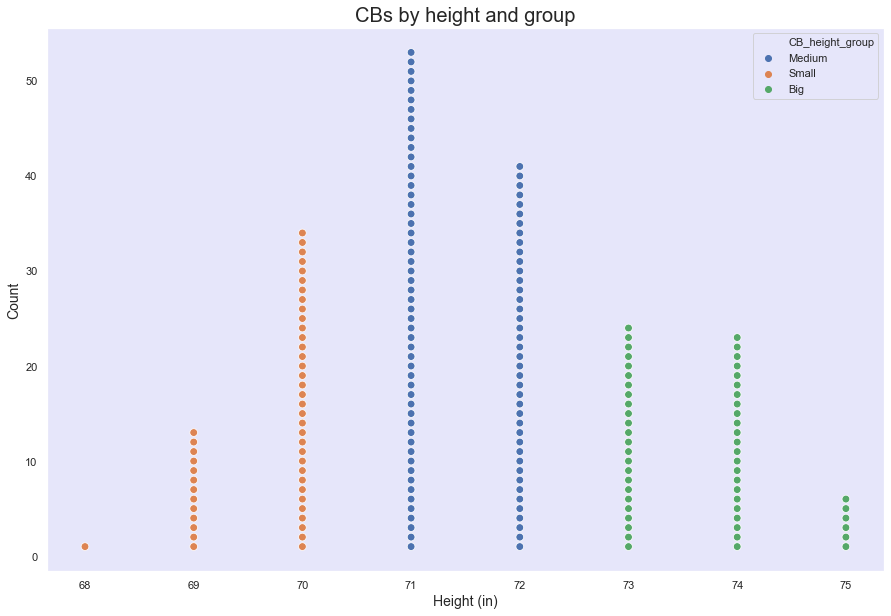

In [5]:
df_players['CB_height_group'] = df_players.apply(lambda x:
                                        None if x['position'] != 'CB' else
                                        'Big' if x['height'] > corner_hgh else
                                        'Small' if x['height'] < corner_low else
                                        'Medium', axis=1)
    
    
cb_clusters_df = df_players[df_players['position'] == 'CB']
viz.create_height_dotplot(cb_clusters_df, "CB")


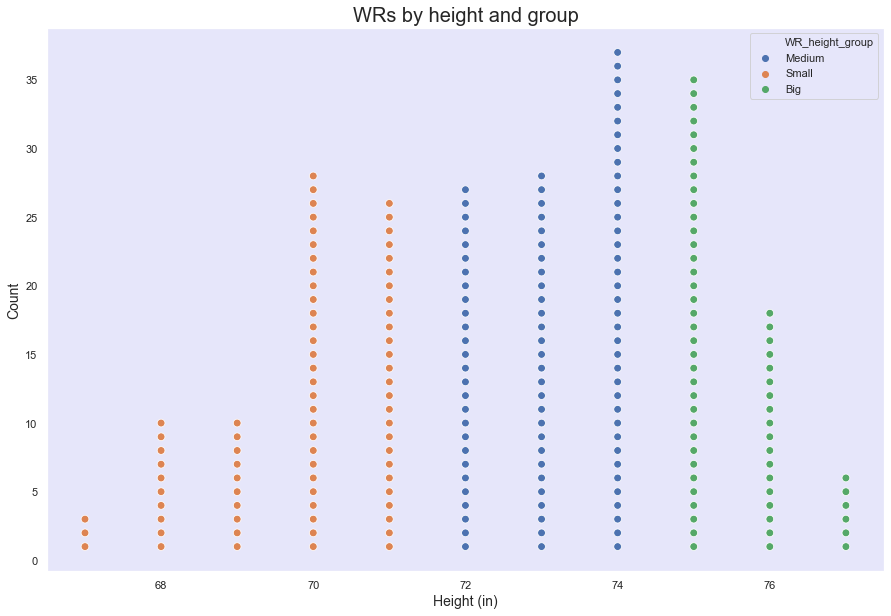

In [6]:
df_players['WR_height_group'] = df_players.apply(lambda x:
                                        None if x['position'] != 'WR' else
                                        'Big' if x['height'] > receiver_hgh else
                                        'Small' if x['height'] <= receiver_low else
                                        'Medium', axis=1)

wr_clusters_df = df_players[df_players['position'] == 'WR']
viz.create_height_dotplot(wr_clusters_df, "WR")

Observation: the distribution of heights for receivers is much less normal, and is somewhat bi-modal and left-skewed.  This is likely due to the nature of rosters having some slot-receivers that are smaller/quicker and more outside receivers that are larger.

##### 1B. Clustering based on height/weight

Adding weight to the equation to divide receivers and CBs into similar groups using k-means clustering.

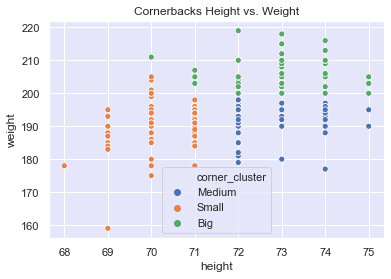

<Figure size 576x432 with 0 Axes>

In [7]:
## Perform clustering for corners
## Normalize height/weight and cluster
corner_X['height_std'] = corner_X['height'].apply(lambda x: (x-np.mean(corner_X['height']))/np.std(corner_X['height']))
corner_X['weight_std'] = corner_X['weight'].apply(lambda x: (x-np.mean(corner_X['weight']))/np.std(corner_X['weight']))
kmeans_corner = KMeans(n_clusters=3, random_state=0).fit(corner_X[['height_std', 'weight_std']])
corner_X['corner_cluster'] = kmeans_corner.labels_

## Dedup and assign meaningful labels
corner_X = corner_X.groupby(['height', 'weight', 'corner_cluster']).size().reset_index().drop(columns=0)
df_players_corner_cluster = df_players[df_players['position'] == 'CB'].merge(corner_X, on = ['height', 'weight'])
df_players_corner_cluster['corner_cluster'] = df_players_corner_cluster['corner_cluster'].apply(lambda x:
                                                     "Big" if x == 1 else "Small" if x==0 else "Medium")


sns.scatterplot(x='height', y='weight', hue = 'corner_cluster', palette="deep",
            data = df_players_corner_cluster)
plt.title('Cornerbacks Height vs. Weight')
plt.figure(figsize=(8, 6))
plt.show()

Not a big fan of the clusters here.  A corner that is 5'10 and 210 should not be "Big" while one that is 6'3 and 195 is "Medium".  Opting to go with the "height only" percentile groupings unless we can find wingspan data.

According to [Football Advantage](https://footballadvantage.com/cornerback/), the most important trait for a cornerback is "good length" in terms of height and wingspan.  Although, they also mention that weighing around 200 lbs. at 6'0" is important because "without that height-weight combo, cornerbacks could easily be pushed around by bigger, taller, stronger wide receivers".

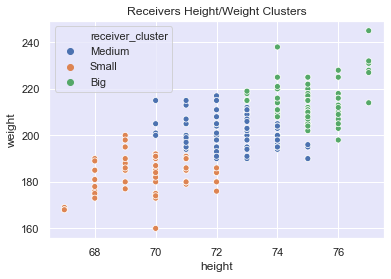

<Figure size 576x432 with 0 Axes>

In [8]:
## Perform clustering for receivers
## Normalize height/weight and cluster
receiver_X['height_std'] = receiver_X['height'].apply(lambda x: (x-np.mean(receiver_X['height']))/np.std(receiver_X['height']))
receiver_X['weight_std'] = receiver_X['weight'].apply(lambda x: (x-np.mean(receiver_X['weight']))/np.std(receiver_X['weight']))
kmeans_receiver = KMeans(n_clusters=3, random_state=0).fit(receiver_X[['height_std', 'weight_std']])
receiver_X['receiver_cluster'] = kmeans_receiver.labels_

## Dedup and assign meaningful labels
receiver_X = receiver_X.groupby(['height', 'weight', 'receiver_cluster']).size().reset_index().drop(columns=0)
df_players_receiver_cluster = df_players[df_players['position'] == 'WR'].merge(receiver_X, on = ['height', 'weight'])
df_players_receiver_cluster['receiver_cluster'] = df_players_receiver_cluster['receiver_cluster'].apply(lambda x:
                                                     "Big" if x == 1 else "Small" if x==2 else "Medium")

sns.scatterplot(x='height', y='weight', hue = 'receiver_cluster', palette="deep",
            data = df_players_receiver_cluster)
plt.title('Receivers Height/Weight Clusters')
plt.figure(figsize=(8, 6))
plt.show()

In [9]:
df_wr_corner_clusters = pd.concat([df_players_receiver_cluster, df_players_corner_cluster])
df_players_w_clusters = df_players.merge(df_wr_corner_clusters[['nflId', 'receiver_cluster', 'corner_cluster']], on = 'nflId', how = 'left')

##### 1C. Clustering with speed and combine metrics

Gathered combine stats for DBs since 2005 from [StatHead's combine search tool](https://stathead.com/football/nfl-combine-results.cgi) (contact me if you want the data, it's behind a subscription paywall, but I got a free trial).

Question: How much does a corner's speed and acceleration contribute to their ability to defend?

Methodology:
  1. Quantify the "game speed" of players that played an adequate number of snaps in 2018 based on their max speed and/or acceleration.
  2. Build a model to predict "game speed" based on combine metrics for DBs that have (also so that coaches may estimate the ability of college prospects before the draft)
  2. Re-cluster based on height and game-speed

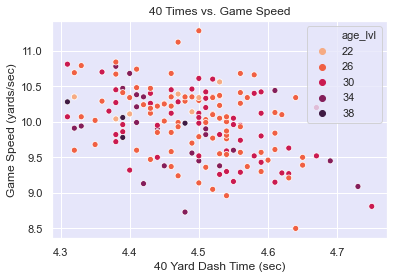

<Figure size 864x576 with 0 Axes>

Pearson correlation coefficient: 
      -0.3978803055455931
Regression coefficient: [-2.14196593]


In [10]:
### Get top game speeds
db_game_speeds_df = du.get_top_speeds(position = 'DB')
db_game_speeds_player_df = db_game_speeds_df.merge(df_players, on='nflId')

## Read in StatHead combine stats (slightly cleaned up to help with merging)
db_combine_stats_df = pd.read_csv("data/created/db_combine_clean.csv")

## Merge the two datasets
db_speed_regression_df = db_game_speeds_player_df.merge(db_combine_stats_df, on = 'displayName', how = 'left')

## Limit to only players with adequate number of plays, realistic speeds, and both a 40 time and max speed observed
db_speed_regression_df = db_speed_regression_df.query("n_plays > 100 & max_speed < 13") # also remove impossible speeds
db_speed_regression_df['age_lvl'] = pd.cut(db_speed_regression_df['age'],[18,22,26,30,34,38],
                                           labels=[22, 26, 30, 34, 38])
db_speed_regression_df = db_speed_regression_df.dropna(subset=['max_speed','40YD','age_lvl'])

## Plot, measure correlation, and build a model
sns.scatterplot(data=db_speed_regression_df, x='40YD', y='max_speed', hue='age_lvl', palette="rocket_r")
plt.title('40 Times vs. Game Speed')
plt.xlabel('40 Yard Dash Time (sec)')
plt.ylabel('Game Speed (yards/sec)')
plt.figure(figsize=(12,8))
plt.show()
print(f"""Pearson correlation coefficient: 
      {np.corrcoef(db_speed_regression_df['max_speed'], 
                   db_speed_regression_df['40YD'])[0,1]}""")

    
## Build the model
X = np.array(db_speed_regression_df['40YD']).reshape(-1, 1)
y = db_speed_regression_df['max_speed']
reg = LinearRegression().fit(X, y)
print(f"Regression coefficient: {reg.coef_}")

In [11]:
## Create a master dataframe with "game speeds" of all DBs, including those imputed by 40 times with few plays.
db_speed_df = db_game_speeds_player_df.merge(db_combine_stats_df, on = 'displayName', how = 'left')

### Predict game speed for all
preds = reg.predict(np.array(db_speed_df[~np.isnan(db_speed_df['40YD'])]['40YD']).reshape(-1,1))
non_null_40_ids = db_speed_df[~np.isnan(db_speed_df['40YD'])]['nflId']
predicted_df = pd.DataFrame({'nflId': non_null_40_ids, 'predicted_game_speed': preds})

### Merge and use raw top speed in game if number of plays is 100 or more, otherwise take the imputed one (indicating if so)
db_speed_df = db_speed_df.merge(predicted_df, on='nflId', how='left')
db_speed_df['game_speed'] = db_speed_df.apply(lambda x: x['max_speed'] if x['n_plays'] >= 100
                                              else x['predicted_game_speed'] if not np.isnan(x['40YD'])
                                              else None, axis=1)
db_speed_df['game_speed_impute_ind'] = db_speed_df.apply(lambda x: False if x['n_plays'] >= 100
                                              else True if not np.isnan(x['40YD'])
                                              else None, axis=1)

## Show the top 25 fastest DBs by "game speed"
display(db_speed_df[['displayName', 'game_speed', 'game_speed_impute_ind']]
        .sort_values('game_speed', ascending=False).head(25))

,displayName,game_speed,game_speed_impute_ind
132,T.J. Carrie,11.79,False
201,Derrick Kindred,11.28,False
224,Briean Boddy-Calhoun,11.12,False
159,Ronald Darby,10.84,False
9,Jason McCourty,10.84,False
153,Trae Waynes,10.81,False
198,Anthony Brown,10.79,False
14,Devin McCourty,10.78,False
183,Jalen Ramsey,10.74,False
96,Darius Slay,10.70,False


According to this, T.J. Carrie (#38 in orange in the plot below) reached the highest game speed of 11.79 yards/sec (24.1 mph) on this play.  In the 2014 NFL Combine he ran a 4.49 in the 40 yard dash, nothing close to this fast.  This seems like an issue with sensor lagging more than an impressive speed.  There was another issue with Eric Weddle in game ID #2018102101, but that was more obviously impossible.

![tj_hauling](img/tj_carrie_hauling.gif)

### 2. Success rates and tendencies for given routes & coverages

#### 2A. EPA/Completion % Based on Receiver/CB profiles and routes

WARNING: Cell below takes a long time to run to identify closest receivers at the time that the ball arrived at the receiver.
 - Skip to the next cell to read in a CSV with results

In [12]:
#### Data wrangling to identify defenders and calculate stats
### 

# Find the closest defender to all of the goal line passes
wr_cb_tracking_df = tracking_df.merge(df_plays, on = ['gameId', 'playId'])
closest_defender_df = du.find_closest_defender_to_ball(wr_cb_tracking_df)

## Merge closest defender and targets
wr_cb_tracking_df = wr_cb_tracking_df.merge(closest_defender_df, how='left', on=['gameId', 'playId'])
wr_cb_tracking_df = wr_cb_tracking_df.merge(df_targets, how='left', on=['gameId', 'playId'])

## Limit to players of interest to save space
wr_cb_tracking_df = wr_cb_tracking_df[((wr_cb_tracking_df['nflId'] == wr_cb_tracking_df['targetNflId']) |
                                     (wr_cb_tracking_df['nflId'] == wr_cb_tracking_df['defenderNflId']))]

## Compile info down to the play level
wr_cb_routes = (wr_cb_tracking_df.groupby(['gameId', 'playId', 'targetNflId', 'defenderNflId', 'distance_to_football',
                                          'route']).size().reset_index().rename(columns={0:'count'}))

## Merge extra info back into play-level DF
wr_cb_plays_df = df_plays.merge(wr_cb_routes, on = ['gameId', 'playId'])

## Completion %
wr_cb_plays_df['completion'] = wr_cb_plays_df.apply(lambda x:
                                     1 if (x['passResult'] == 'C') 
                                     else 0 if x['passResult'] in ['I', 'IN']
                                     else None, axis=1)

## Pass interference %
wr_cb_plays_df['pass_interference'] =  wr_cb_plays_df['isDefensivePI'].apply(lambda x: 1 if x else 0) 

## Merge in Receiver/defender info
df_players_w_clusters.columns = [c+'_receiver' if c not in ['nflId', 'receiver_cluster', 'corner_cluster',
                                                           'WR_height_group', 'CB_height_group']
                      else c for c in df_players_w_clusters.columns]
wr_cb_plays_df = wr_cb_plays_df.merge(df_players_w_clusters[['nflId', 'displayName_receiver', 'receiver_cluster',
                                                            'WR_height_group']],
                                              how='left', left_on = 'targetNflId',
                                              right_on = 'nflId')
df_players_w_clusters.columns = [c.replace('_receiver', '_defender') if c not in ['nflId', 'receiver_cluster',
                                                                                  'corner_cluster',
                                                                                 'WR_height_group', 'CB_height_group']
                      else c for c in df_players_w_clusters.columns]
wr_cb_plays_df = wr_cb_plays_df.merge(df_players_w_clusters[['nflId', 'displayName_defender', 'corner_cluster',
                                                             'CB_height_group']],
                                              how='left', left_on = 'defenderNflId',
                                              right_on = 'nflId')
df_players_w_clusters.columns = [c.replace('_defender', '') for c in df_players_w_clusters.columns]

## Group by receiver type/corner type/route and calculate EPA and count
route_clusters_epa_df = (wr_cb_plays_df
                        .groupby(['receiver_cluster', 'corner_cluster', 'route'])
                        .agg({'epa': np.mean,
                              'completion': np.mean,
                              'pass_interference': np.mean,
                              'playId': len})
                        .reset_index()
                        .rename(columns={'epa': 'avg_epa',
                                         'completion':'completion_pct',
                                         'pass_interference': 'pass_interference_pct',
                                         'playId': 'targeted_cnt'})
                        .sort_values('avg_epa'))



In [13]:
wr_cb_plays_df = pd.read_csv("data/created/wr_cb_plays.csv")

## Group by receiver type/corner type/route and calculate EPA and count
route_clusters_epa_df = (wr_cb_plays_df
                        .groupby(['receiver_cluster', 'corner_cluster', 'route'])
                        .agg({'epa': np.mean,
                              'completion': np.mean,
                              'pass_interference': np.mean,
                              'playId': len})
                        .reset_index()
                        .rename(columns={'epa': 'avg_epa',
                                         'completion':'completion_pct',
                                         'pass_interference': 'pass_interference_pct',
                                         'playId': 'targeted_cnt'})
                        .sort_values('avg_epa'))


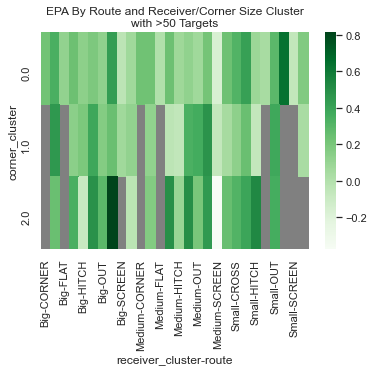

<Figure size 576x432 with 0 Axes>

In [14]:
##### All combinations with > 50 targets
decent_n_routes = route_clusters_epa_df[route_clusters_epa_df['targeted_cnt'] > 50]

decent_n_pivot = pd.pivot_table(data=decent_n_routes,
                    index='corner_cluster',
                    values='avg_epa',
                    columns=['receiver_cluster', 'route'])

g = sns.heatmap(decent_n_pivot, cmap = 'Greens')
g.set_facecolor('gray')
plt.title('EPA By Route and Receiver/Corner Size Cluster\nwith >50 Targets')
plt.figure(figsize=(8, 6))
plt.show()

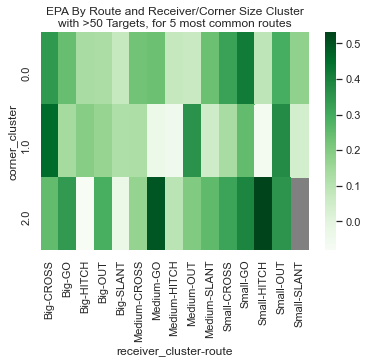

<Figure size 576x432 with 0 Axes>

In [15]:
##### Top 5 route types (and >50 targets)
top_5_routes = list(wr_cb_plays_df.route.value_counts().index)[0:5]
top_5_routes_df = decent_n_routes[decent_n_routes['route'].isin(top_5_routes)]

top_5_rts_pivot = pd.pivot_table(data=top_5_routes_df,
                    index='corner_cluster',
                    values='avg_epa',
                    columns=['receiver_cluster', 'route'])

g = sns.heatmap(top_5_rts_pivot, cmap = 'Greens')
g.set_facecolor('gray')
plt.title('EPA By Route and Receiver/Corner Size Cluster\nwith >50 Targets, for 5 most common routes')
plt.figure(figsize=(8, 6))
plt.show()


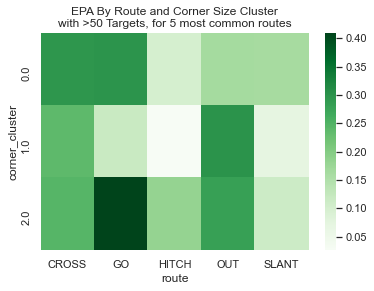

<Figure size 576x432 with 0 Axes>

In [16]:
### Removing Receiver Cluster from top 5 routes heatmap
top_5_rts_no_wr_pivot = pd.pivot_table(data=top_5_routes_df,
                    index='corner_cluster',
                    values='avg_epa',
                    columns='route')

g = sns.heatmap(top_5_rts_no_wr_pivot, cmap = 'Greens')
g.set_facecolor('gray')
plt.title('EPA By Route and Corner Size Cluster\nwith >50 Targets, for 5 most common routes')
plt.figure(figsize=(8, 6))
plt.show()

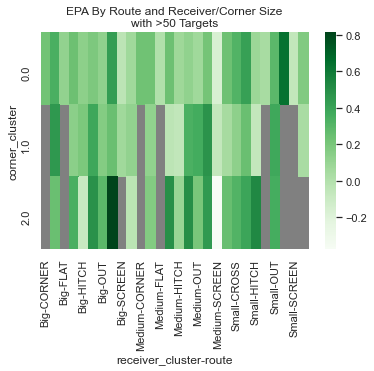

<Figure size 576x432 with 0 Axes>

In [17]:
#### Visualizations of EPA by Route/Receiver Type/Corner Type

decent_n_pivot = pd.pivot_table(data=decent_n_routes,
                    index='corner_cluster',
                    values='avg_epa',
                    columns=['receiver_cluster', 'route'])

g = sns.heatmap(decent_n_pivot, cmap = 'Greens')
g.set_facecolor('gray')
plt.title('EPA By Route and Receiver/Corner Size\nwith >50 Targets')
plt.figure(figsize=(8, 6))
plt.show()

In [18]:
wr_cb_plays_ht_df = wr_cb_plays_df.merge(df_players_w_clusters[['nflId', 'WR_height_group']],
                                              how='left', left_on = 'targetNflId',
                                              right_on = 'nflId')
wr_cb_plays_ht_df = wr_cb_plays_ht_df.merge(df_players_w_clusters[['nflId', 'CB_height_group']],
                                              how='left', left_on = 'defenderNflId',
                                              right_on = 'nflId')


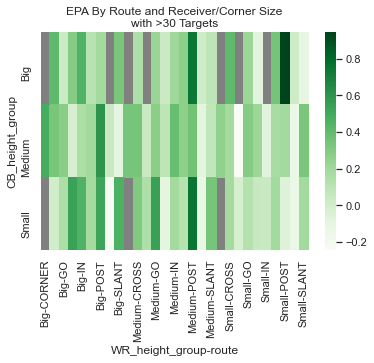

<Figure size 576x432 with 0 Axes>

In [19]:
## Group by receiver type/corner type/route and calculate EPA and count
route_ht_grps_epa_df = (wr_cb_plays_ht_df
                        .groupby(['WR_height_group', 'CB_height_group', 'route'])
                        .agg({'epa': np.mean,
                              'completion': np.mean,
                              'pass_interference': np.mean,
                              'playId': len})
                        .reset_index()
                        .rename(columns={'epa': 'avg_epa',
                                         'completion':'completion_pct',
                                         'pass_interference': 'pass_interference_pct',
                                         'playId': 'targeted_cnt'})
                        .sort_values('avg_epa'))

##### All combinations with > 30 targets
decent_n_routes = route_ht_grps_epa_df[route_ht_grps_epa_df['targeted_cnt'] > 30]

decent_n_pivot = pd.pivot_table(data=decent_n_routes,
                    index='CB_height_group',
                    values='avg_epa',
                    columns=['WR_height_group', 'route'])

g = sns.heatmap(decent_n_pivot, cmap = 'Greens')
g.set_facecolor('gray')
plt.title('EPA By Route and Receiver/Corner Size\nwith >30 Targets')
plt.figure(figsize=(8, 6))
plt.show()

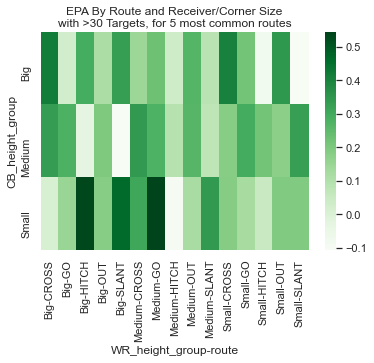

<Figure size 576x432 with 0 Axes>

In [20]:
##### Top 5 route types (and >30 targets)
top_5_routes = list(wr_cb_plays_ht_df.route.value_counts().index)[0:5]
top_5_routes_df = decent_n_routes[decent_n_routes['route'].isin(top_5_routes)]

top_5_rts_pivot = pd.pivot_table(data=top_5_routes_df,
                    index='CB_height_group',
                    values='avg_epa',
                    columns=['WR_height_group', 'route'])

g = sns.heatmap(top_5_rts_pivot, cmap = 'Greens')
g.set_facecolor('gray')
plt.title('EPA By Route and Receiver/Corner Size\nwith >30 Targets, for 5 most common routes')
plt.figure(figsize=(8, 6))
plt.show()

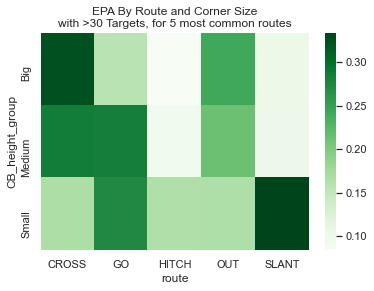

<Figure size 576x432 with 0 Axes>

In [21]:
### Removing Receiver Cluster from top 5 routes heatmap
top_5_rts_no_wr_pivot = pd.pivot_table(data=top_5_routes_df,
                    index='CB_height_group',
                    values='avg_epa',
                    columns='route')

g = sns.heatmap(top_5_rts_no_wr_pivot, cmap = 'Greens')
g.set_facecolor('gray')
plt.title('EPA By Route and Corner Size\nwith >30 Targets, for 5 most common routes')
plt.figure(figsize=(8, 6))
plt.show()

We can see from this that bigger corners have issues defending crossing routes.  Crossing routes seem to be most linearly related to height, with small corners having the most success defending them.

However, small corners have a tough time guarding go routes (straight to the end-zone) and slants.  The result with slant routes is somewhat surprising to me, as they are generally quick hits that don't involve as much physicality as a jump ball.  This may have something to do with smaller defender's ability to reach around a receiver to knock the ball away without being called for interference.  This is something to investigate further.

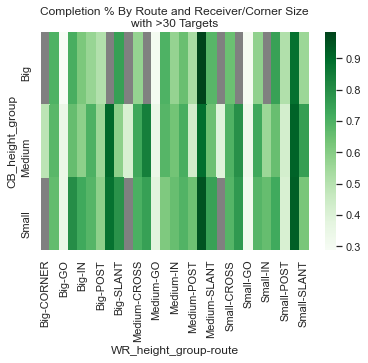

<Figure size 576x432 with 0 Axes>

In [22]:
### Pivot using Completion PCT as value
decent_n_pivot = pd.pivot_table(data=decent_n_routes,
                    index='CB_height_group',
                    values='completion_pct',
                    columns=['WR_height_group', 'route'])

## All combinations with >30 targets
g = sns.heatmap(decent_n_pivot, cmap = 'Greens')
g.set_facecolor('gray')
plt.title('Completion % By Route and Receiver/Corner Size\nwith >30 Targets')
plt.figure(figsize=(8, 6))
plt.show()

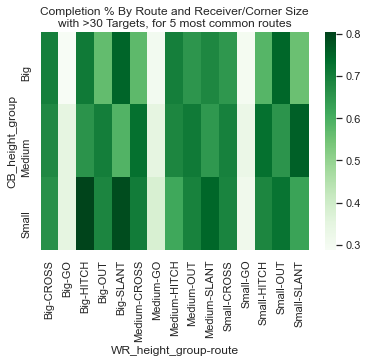

<Figure size 576x432 with 0 Axes>

In [23]:
##### Top 5 route types (and >30 targets)
top_5_routes = list(wr_cb_plays_ht_df.route.value_counts().index)[0:5]
top_5_routes_df = decent_n_routes[decent_n_routes['route'].isin(top_5_routes)]

top_5_rts_pivot = pd.pivot_table(data=top_5_routes_df,
                    index='CB_height_group',
                    values='completion_pct',
                    columns=['WR_height_group', 'route'])

g = sns.heatmap(top_5_rts_pivot, cmap = 'Greens')
g.set_facecolor('gray')
plt.title('Completion % By Route and Receiver/Corner Size\nwith >30 Targets, for 5 most common routes')
plt.figure(figsize=(8, 6))
plt.show()

Follow-up on note about small corners defending slants.  This effect appears even more dramatic when receivers are larger.

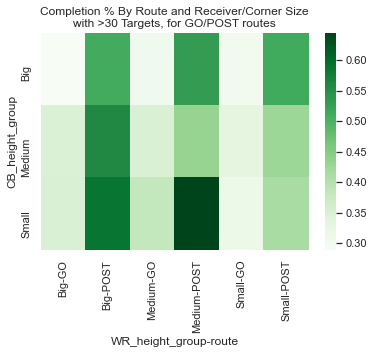

<Figure size 576x432 with 0 Axes>

In [24]:
##### Deep route types (and >50 targets)
deep_routes = ['GO', 'POST']
deep_routes_df = decent_n_routes[decent_n_routes['route'].isin(deep_routes)]

deep_rts_pivot = pd.pivot_table(data=deep_routes_df,
                    index='CB_height_group',
                    values='completion_pct',
                    columns=['WR_height_group', 'route'])

g = sns.heatmap(deep_rts_pivot, cmap = 'Greens')
g.set_facecolor('gray')
plt.title('Completion % By Route and Receiver/Corner Size\nwith >30 Targets, for GO/POST routes')
plt.figure(figsize=(8, 6))
plt.show()

Go and Post routes are some of the biggest "boom or bust" plays.  In general they have a relatively low-probability of success/completion; but post routes seem to have a higher probability of success when a smaller corner is defending a bigger receiver.

Go routes have an extremely low probablity of success in all of the plots above.  Part of this may be due to desperation "hail mary" plays, so eliminating these plays would be helpful.

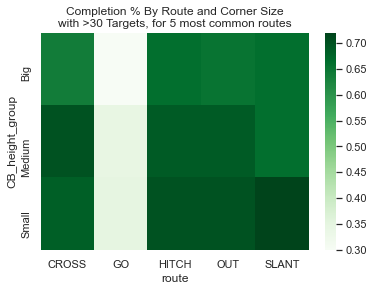

<Figure size 576x432 with 0 Axes>

In [25]:
### Removing Receiver Cluster from top 5 routes heatmap
top_5_rts_no_wr_pivot = pd.pivot_table(data=top_5_routes_df,
                    index='CB_height_group',
                    values='completion_pct',
                    columns='route')

g = sns.heatmap(top_5_rts_no_wr_pivot, cmap = 'Greens')
g.set_facecolor('gray')
plt.title('Completion % By Route and Corner Size\nwith >30 Targets, for 5 most common routes')
plt.figure(figsize=(8, 6))
plt.show()

LOTS TO DO:
 - Analyze tendencies of teams to run certain routes/coverages in given situations
 - Recommendation algorithm to propose matchups based on estimated success of defenders given a matchup against receivers in certain situations